# AD U-Net + Stardist

#### How to Use

1. To run demo data, click the three run buttons '▷' in order
2. To run you own data, allow Google Drive request while runing the first cell, and replace 'Source_image' path with your ***tif*** file path.

##### How to replace file path
1. Click the folder button '🗂️' on the left. Click 'drive', and find data at your google drive. Click '⋮' button on the right of you file. Click 'copy path', and then paste it on the second cell



In [2]:
%%capture
#@markdown ##Initilization and Model Loading(Take up to 5 mins)
!pip install stardist > /dev/null 2>&1
!pip -q install csbdeep

import numpy as np
from csbdeep.utils import Path, normalize
import skimage
import pandas as pd
import csv
import time
from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist import star_dist,edt_prob
import tensorflow as tf

from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.utils.prune as prune

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from PIL import Image, ImageOps

import requests
import zipfile
import io
from glob import glob

from collections import Counter
from matplotlib.patches import Patch
from scipy import ndimage
import cv2
a = input('Do you want to connect to Google Drive to use your own data?(y/n)')
if a.lower() == 'y' or a.lower() == 'yes':
    from google.colab import drive
    drive.mount('/content/drive')

# AD Unet Structure

def match_size(source, target):
    # print(f'targer:{target.size()}, source: {source.size()}')
    return F.interpolate(source, size=target.shape[1:], mode='bilinear', align_corners=False)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class inConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, res = False):
        super().__init__()
        self.res = res
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        out = self.maxpool_conv(x)

        return out

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False,
                 res = False):
        super().__init__()
        self.res = res
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        out = self.conv(x)

        return out

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, learn = 0.0025,
                 resconv = True):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = inConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.att1 = AttentionGate(512, 256, 256)
        self.att2 = AttentionGate(256, 128, 128)
        self.att3 = AttentionGate(128, 64, 64)
        self.att4 = AttentionGate(64, 32, 32)

        self.up1 = Up(512, 256, bilinear, res = resconv)
        self.up2 = Up(256, 128, bilinear, res = resconv)
        self.up3 = Up(128, 64, bilinear, res = resconv)
        self.up4 = Up(64, 32, bilinear)

        self.out1 = OutConv(256, n_classes)
        self.out2 = OutConv(128, n_classes)
        self.out3 = OutConv(64, n_classes)
        self.outc = OutConv(32, n_classes)

        # self.inc = inConv(n_channels, 64)
        # self.down1 = Down(64, 128)
        # self.down2 = Down(128, 256)
        # self.down3 = Down(256, 512)
        # self.down4 = Down(512, 1024)

        # self.att1 = AttentionGate(1024, 512, 512)
        # self.att2 = AttentionGate(512, 256, 256)
        # self.att3 = AttentionGate(256, 128, 128)
        # self.att4 = AttentionGate(128, 64, 64)

        # self.up1 = Up(1024, 512, bilinear, res = resconv)
        # self.up2 = Up(512, 256, bilinear, res = resconv)
        # self.up3 = Up(256, 128, bilinear, res = resconv)
        # self.up4 = Up(128, 64, bilinear)

        # self.out1 = OutConv(512, n_classes)
        # self.out2 = OutConv(256, n_classes)
        # self.out3 = OutConv(128, n_classes)
        # self.outc = OutConv(64, n_classes)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.8)

        self.history = {"train_loss": [], "val_loss": []}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        x4 = self.att1(x5, x4)
        x = self.up1(x5, x4)
        out1 = self.out1(x)

        x3 = self.att2(x, x3)
        x = self.up2(x, x3)
        out2 = self.out2(x)

        x2 = self.att3(x, x2)
        x = self.up3(x, x2)
        out3 = self.out3(x)

        x1 = self.att4(x, x1)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, out1, out2, out3

    def ce_loss(self, pred_mask, target_mask, weighted=False):
        target_mask = target_mask.squeeze(1).type(torch.long)
        if weighted:
            weight = torch.ones(pred_mask.shape[1], device=self.device)
            weight[0] = 10
            weight[1] = 10
            weight[2] = 10
            loss = F.cross_entropy(pred_mask, target_mask, weight=weight)
        else:
            loss = F.cross_entropy(pred_mask, target_mask)
        return loss

    def focal_loss(self, inputs, targets, alpha=0.25, gamma=2.0, epsilon=1e-9):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)  # [batch_size, 1, height, width] to [batch_size, height, width]
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        inputs = inputs.clamp(min=epsilon, max=1.0 - epsilon)
        pt = torch.where(torch.eq(targets, 1), inputs, 1 - inputs)
        loss = -alpha * (1 - pt) ** gamma * torch.log(pt)

        return loss.mean()

    def dice_loss(self,inputs, targets, class_weights=[0.5, 1, 1.5, 1], smooth=1e-6):
        inputs = F.softmax(inputs, dim=1)
        targets = targets.squeeze(1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = 2.0 * (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_score = (intersection + smooth) / (union + smooth)

        class_weights = torch.tensor(class_weights, device=inputs.device, dtype=inputs.dtype)
        dice_loss = (1 - dice_score) * class_weights

        return dice_loss.mean()

    def combined_loss(self, inputs, targets, alpha=0.5, beta=0.5, gamma=2.0, smooth=1e-6):
        loss_focal = self.focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
        loss_dice = self.dice_loss(inputs, targets, smooth=smooth)
        return beta * loss_focal + (1 - beta) * loss_dice


    def train_step(self, inputs, target_mask, lossfunc):
        inputs, target_mask = inputs.to(self.device), target_mask.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_mask, out1, out2, out3 = self(inputs)
        mask_loss = lossfunc(pred_mask, target_mask)
        mask_loss1 = lossfunc(match_size(out1,target_mask), target_mask)
        mask_loss2 = lossfunc(match_size(out2,target_mask), target_mask)
        mask_loss3 = lossfunc(match_size(out3,target_mask), target_mask)
        all = mask_loss+mask_loss1+mask_loss2+mask_loss3

        all.backward()
        self.optimizer.step()
        # print(f'mask loss:{mask_loss}, loss1{mask_loss1}, loss2{mask_loss2}, loss3:{mask_loss3}')
        return mask_loss.item()

        mask_loss.backward()
        self.optimizer.step()
        return mask_loss.item()

    def validate(self, val_loader, lossfunc):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask in val_loader:
                target_mask = target_mask.long()
                inputs, target_mask = inputs.to(device), target_mask.to(device)
                pred_mask, out1, out2, out3 = self(inputs)
                mask_loss = lossfunc(pred_mask, target_mask)
                total_loss += mask_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, epochs, batch_size, val_loader= None, loss='dice_loss', best_loss = 10):
        alloss = {'dice_loss': self.dice_loss, 'focal_loss': self.focal_loss,
                  'combined_loss': self.combined_loss, 'ce_loss': self.ce_loss}
        lossfunc = alloss[loss]

        for epoch in range(epochs):
            start_time = time.time()

            # n_val = int(len(full_dataset) * val_percent)
            # n_train = len(full_dataset) - n_val
            # train_subset, val_subset = torch.utils.data.random_split(full_dataset, [n_train, n_val])

            # train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            # val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

            total_train_loss = 0
            for inputs, target_mask in train_loader:
                target_mask = target_mask.long()
                mask_loss = self.train_step(inputs, target_mask, lossfunc)
                total_train_loss += mask_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader, lossfunc)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 0
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('/content/best_unet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def predict(self, x):
        x = x.to(self.device)
        self.eval()
        with torch.no_grad():
            preds = self(x)
            preds = preds.argmax(dim=1)  #  (batch_size, height, width)

            preds = preds.float() / (self.n_classes - 1) * 255
            preds = preds.to(torch.uint8)

            return preds

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = UNet(n_channels, n_classes, bilinear)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


class BasicDataset(Dataset):
    def __init__(self, images_dir, masks_dir,
                 augmentation=False, mirror=True, rotate=True,
                 clahe = False,
                 edgeCanny = False,
                 lbp = False,
                 houghTransform = True,
                 surf = True):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.augmentation = augmentation
        self.clahe = clahe
        self.edgeCanny = edgeCanny
        self.lbp = lbp
        self.houghTransform = houghTransform
        self.surf = surf

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.7, 1.3), saturation=(0.8, 1.2)),
        ])
        # self.transtensor = transforms.ToTensor()

        self.images = [file for file in os.listdir(images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(masks_dir) if file.endswith('.png')]
        # print(f'images: {len(self.images)}, masks: {len(self.masks)}')

        if self.augmentation:
            self.apply_augmentation(mirror, rotate)

    def apply_augmentation(self, mirror, rotate):
        for img_name in self.images:
            img_path = os.path.join(self.images_dir, img_name)
            image = Image.open(img_path).convert("L")

            if mirror:
                mirrored_image = ImageOps.mirror(image)
                mirrored_image.save(os.path.join(self.images_dir, f'mirror_{img_name}'))

            if rotate:
                rotated_image = image.rotate(180)
                rotated_image.save(os.path.join(self.images_dir, f'rotate_{img_name}'))

        for mask_name in self.masks:
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path).convert("L")

            if mirror:
                mirrored_mask = ImageOps.mirror(mask)
                mirrored_mask.save(os.path.join(self.masks_dir, f'mirror_{mask_name}'))

            if rotate:
                rotated_mask = mask.rotate(180)
                rotated_mask.save(os.path.join(self.masks_dir, f'rotate_{mask_name}'))

        # Update the lists of images and masks after augmentation
        self.images = [file for file in os.listdir(self.images_dir) if file.endswith('.png')]
        self.masks = [file for file in os.listdir(self.masks_dir) if file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        image_np = np.array(image)
        image_transform = self.transform(image_np)
        channels = [image_transform]
        channels[0] = channels[0].squeeze(0).numpy()

        # if self.clahe:
        #     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #     image_clahe = clahe.apply(image_np)
        #     channels.append(image_clahe)

        # if self.edgeCanny:
        #     edges = cv2.Canny(image_np, 100, 200)
        #     channels.append(edges)

        # if self.lbp:
        #     lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
        #     lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #     channels.append(lbp_image_normalized)

        # Stack all the channels together
        # print(len(channels))
        if len(channels) > 1:
            # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
            image_combined = np.stack(channels, axis=-1)
        else:
            image_combined = channels[0]

        image_combined = torch.from_numpy(image_combined).float()
        # print(image_combined.size())
        if len(image_combined.size())==3:
            image_combined = image_combined.permute(2, 0, 1)
        else:
            image_combined = image_combined.unsqueeze(0)
        mask = torch.from_numpy(np.array(mask))

        return image_combined, mask

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageOps
from torchvision import transforms
from skimage.feature import local_binary_pattern
from sklearn.model_selection import KFold
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm

import numpy as np
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D
from csbdeep.utils import Path, normalize
import skimage
import pandas as pd
import csv
import time
from tifffile import imread, imwrite
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist import random_label_cmap
import tensorflow as tf

from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.utils.prune as prune

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from PIL import Image, ImageOps

import requests
import zipfile
import io
from glob import glob

from collections import Counter
from matplotlib.patches import Patch
from scipy import ndimage
# import cv2

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        #print("gate",g.size(),'x', x.size())
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        #print(g1.size(), x1.size())
        diffY = x.size()[2] -g1.size()[2]
        diffX = x.size()[3] - g1.size()[3]
        g1 = F.pad(g1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        num_groups = out_ch // 8
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 5, padding=2),
            nn.GroupNorm(num_channels=out_ch,num_groups=num_groups),
            nn.ELU(inplace=True),
            #nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 5, padding=2),
            nn.GroupNorm(num_channels=out_ch,num_groups=num_groups),
            nn.ELU(inplace=True)
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()


        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Star_unet(nn.Module):
    def __init__(self, n_channels,
                 n_rays = 64, bilinear=False, learn = 0.0025):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
        print(f'model device:{self.device}')
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        super(Star_unet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = inconv(n_channels, 32)
        self.down1 = down(32, 64)
        self.down2 = down(64, 128)
        #self.down3 = down(128, 256)
        #self.down4 = down(256, 512)
        #self.up1 = up(768, 256,bilinear=True)
        #self.up2 = up(384, 128,bilinear=True)
        self.up3 = up(192, 64,bilinear=True)
        self.up4 = up(96, 32,bilinear=True)
        self.features = nn.Conv2d(32,128,3,padding=1)
        self.out_ray = outconv(128, n_rays)
        self.final_activation_ray = nn.ReLU()
        self.out_prob = outconv(128, 1)
        self.final_activation_prob = nn.Sigmoid()

        # self.att1 = AttentionGate(512, 256, 256)
        # self.att2 = AttentionGate(256, 128, 128)
        # self.att3 = AttentionGate(128, 64, 64)
        # self.att4 = AttentionGate(64, 32, 32)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learn)

        self.history = {"train_loss": [], "val_loss": [], "val_mask_loss": [], "val_star_loss":[]}

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)

        # x4 = self.att1(x5, x4)
        #x = self.up1(x5, x4)

        # x3 = self.att2(x, x3)
        # x = self.up2(x4, x3)

        # x2 = self.att3(x, x2)
        x = self.up3(x3, x2)

        # x1 = self.att4(x, x1)
        x = self.up4(x, x1)
        x = self.features(x)
        out_ray = self.out_ray(x)
        out_ray = self.final_activation_ray(out_ray)
        out_prob = self.out_prob(x)
        out_prob = self.final_activation_prob(out_prob)
        return [out_ray,out_prob]


    def l1_bce_loss(self, prediction, target_dists, labels, scale=[1, 1]):
        """
        custom loss function, combine li loss and bineary ce loss
        :param prediction: model output, including distance and prob
        :param target_dists: distance
        :param labels: label(0 or 1)
        :param scale: weight factor
        """

        assert len(scale) == 2, "Scale list must have two elements."

        predicted_dists, predicted_probs = prediction
        '''print(f'target_dists shape: {target_dists.shape}')
        print(f'labels shape: {labels.shape}')
        print(f'predicted_dists shape: {predicted_dists.shape}')
        print(f'predicted_probs shape: {predicted_probs.shape}')'''
        # predicted_dists, predicted_probs = predicted_dists.to(self.device), predicted_probs.to(self.device)
        target_dists = target_dists.to(self.device)
        labels = labels.to(self.device)
        l1_loss = F.l1_loss(predicted_dists, target_dists, reduction='mean')
        bce_loss = F.binary_cross_entropy(predicted_probs, labels, reduction='mean')
        # print(f'f1loss: {l1_loss}, bceloss: {bce_loss}')

        return scale[0] * l1_loss + scale[1] * bce_loss

    def train_step(self, inputs,obj_prob, dist):
        inputs = inputs.to(self.device)
        self.train()
        self.optimizer.zero_grad()
        pred_list = self(inputs)
        star_loss = self.l1_bce_loss(prediction = pred_list, target_dists = dist, labels = obj_prob, scale=[1, 1])

        star_loss.backward()
        self.optimizer.step()
        return star_loss.item()

    def validate(self, val_loader):
        self.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, target_mask, obj_prob, dist in val_loader:
                inputs, obj_prob, dist = inputs.to(self.device), obj_prob.to(self.device), dist.to(self.device)
                pred_list = self(inputs)
                star_loss = self.l1_bce_loss(prediction = pred_list, target_dists = dist, labels = obj_prob, scale=[1, 1])
                total_loss += star_loss.item()
        return total_loss / len(val_loader)

    def train_model(self, train_loader, val_loader, epochs, batch_size, best_loss = 10):

        for epoch in range(epochs):
            start_time = time.time()

            total_train_loss = 0
            for inputs, target_mask, obj_prob, dist in train_loader:
                star_loss = self.train_step(inputs, obj_prob, dist)
                total_train_loss += star_loss
            avg_train_loss = total_train_loss / len(train_loader)
            self.history["train_loss"].append(avg_train_loss)

            end_time = time.time()
            elapsed_time = end_time - start_time

            if val_loader:
                avg_val_loss = self.validate(val_loader)
                self.history["val_loss"].append(avg_val_loss)
            else:
                avg_val_loss = 'N/A'
            all_loss = avg_val_loss+avg_train_loss
            if all_loss<best_loss:
                best_loss = all_loss
                self.save_model('best_starunet.pth')
                print(f'best model update: {best_loss}')

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss} Time: {elapsed_time:.2f} sec")

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def save_model(self, file_path):
        torch.save(self.state_dict(), file_path)

    @staticmethod
    def load_model(file_path, n_channels, n_classes, bilinear=False):
        model = Star_unet(n_channels = n_channels)
        model.load_state_dict(torch.load(file_path, map_location=model.device))
        return model


# Define the Zenodo link
zenodo_link = "https://zenodo.org/records/11123553/files/models.zip?download=1"
#model1:"https://zenodo.org/records/10655519/files/starunet.zip?download=1"
#model2:"https://zenodo.org/records/10683423/files/model2.zip?download=1"
# Download the file
response = requests.get(zenodo_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Specify the destination folder for extraction
destination_folder = '/content'


# Extract the contents of the zip file to the destination folder
zip_file.extractall(destination_folder)

# Close the zip file
zip_file.close()

!rm -rf model/__MACOSX/

zenodo_link = "https://zenodo.org/records/10656286/files/small.tif?download=1"
response = requests.get(zenodo_link)

destination_path = '/content/demo.tif'

with open(destination_path, 'wb') as file:
    file.write(response.content)

Do you want to connect to Google Drive to use your own data?(y/n)n


In [22]:
# %%capture
#@markdown ###Run models

from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap,ray_angles,draw_polygons
import numpy as np
from skimage.measure import label
import pickle
import shutil

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os

# ref_path= './content/test/imgs/frame50_35.tif'#@param{type:"string"}
starmodel= '/content/models/starunet.pth'#@param{type:"string"}
# ref_img = np.array(Image.open(ref_path).convert("L"))
unetmodel= "/content/models/final_unet.pth"#@param{type:"string"}


def showimg(src_img,ref_img,matched_img):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(src_img, cmap='gray')
    plt.title('Source Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ref_img, cmap='gray')
    plt.title('Reference Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(matched_img, cmap='gray')
    plt.title('Matched Image')
    plt.axis('off')

    plt.show()

def match_histograms(src_img, ref_img):

    src_hist, src_bins = np.histogram(src_img.flatten(), 256, [0,256])
    ref_hist, ref_bins = np.histogram(ref_img.flatten(), 256, [0,256])

    src_cdf = src_hist.cumsum() / src_hist.sum()
    ref_cdf = ref_hist.cumsum() / ref_hist.sum()

    cdf_mapping = np.zeros(256, dtype=np.uint8)
    j = 0
    for i in range(256):
        while ref_cdf[j] < src_cdf[i] and j < 255:
            j += 1
        cdf_mapping[i] = j

    src_img_matched = cdf_mapping[src_img.flatten()]
    src_img_matched = src_img_matched.reshape(src_img.shape).astype(np.uint8)

    return src_img_matched

def ezmatch(src_img, ref_img):
    avesrc = np.mean(src_img)
    averef = np.mean(ref_img)

    factor = averef/avesrc
    src_img = factor*np.array(src_img)
    return src_img.astype(np.uint8)

Source_image = "demo.tif"  #@param{type:"string"}
Stardist_probability_threshold = 0.6 #@param{type:"number"}
# preprocess
import tifffile as tiff

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

def process_tiff(file_path):
    img = tiff.imread(file_path)

    if img.ndim == 4:
        channel_data = img[:, :, :, 0]

        if channel_data.dtype == np.uint16:
            channel_data = (channel_data / 256).astype(np.uint8)

        processed_file_path = file_path.replace('.tif', '_processed.tif')
        tiff.imwrite(processed_file_path, channel_data)

        return processed_file_path

    elif img.ndim == 3:
        img = img[:, :, 0]
        if img.dtype == np.uint16:
            img = (img / 256).astype(np.uint8)
            processed_file_path = file_path.replace('.tif', '_processed.tif')
            tiff.imwrite(processed_file_path, img)
            return processed_file_path
        else:
            return file_path
    elif img.ndim == 2:
        if img.dtype == np.uint16:
            img = (img / 256).astype(np.uint8)
            return processed_file_path
        else:
            return file_path

Source_image = process_tiff(Source_image)

#split video

if Source_image.split('.')[-1] == 'tif':
    img = tiff.TiffFile(Source_image).asarray()
else:
    img = cv2.imread(Source_image, cv2.IMREAD_UNCHANGED)

save_folder = 'processing'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

if len(img.shape) == 3:
    for t in range(img.shape[0]):
        frame = img[t, :, :]
        frame_filename = os.path.join(save_folder, f'frame_{t}.png')
        cv2.imwrite(frame_filename, frame)
elif len(img.shape) == 2:
    frame = img.copy()
    frame_filename = os.path.join(save_folder, f"{Source_image.split('/')[-1]}")
    cv2.imwrite(frame_filename, frame)


# Stardist
Source_images_folder = './processing'
close_processing_images = True #@param{type:"boolean"}
# doclahe = False #@param{type:"boolean"}
# edgeCanny = False #@param{type:"boolean"}
# lbp = False #@param{type:"boolean"}

def starpre(folder):
    base_path = './content/'
    # m1: /content/model/starunet m2:/content/model/model2
    model_name = 'star'
    save_folder = os.path.join(base_path, model_name, "Predictions")
    save_folder2 = os.path.join(base_path, model_name, "outputs")
    save_folder3 = os.path.join(base_path, model_name, "coords")

    os.makedirs(save_folder, exist_ok=True)
    os.makedirs(save_folder2, exist_ok=True)
    os.makedirs(save_folder3, exist_ok=True)

    Source_QC_folder_tif = os.path.join(folder, "*")
    # print(Source_QC_folder_tif)
    Z = sorted(glob(Source_QC_folder_tif))
    file_paths = Z.copy()
    Z = list(map(imread, Z)) if Z[0].split('.')[-1] == 'tif' else [skimage.io.imread(str(file_path)) for file_path in Z]
    n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

    model = Star_unet.load_model(starmodel, n_channels=1, n_classes=4) #./content/best_starunet1cp75.pth
    model = model.to(device)

    axis_norm = (0, 1) if n_channel == 1 else (0, 1, 2)
    lbl_cmap = random_label_cmap()

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    # print(len(Z))

    for i, img in tqdm(enumerate(Z), total=len(Z)):
        image_np = np.array(img)
        image_np = (image_np*(23/np.mean(image_np))).astype(np.uint8) #23 is close to train set of the model
        # image = ezmatch(image_np, ref_img)
        img_normalized = normalize(image_np, 1, 99, axis=axis_norm)
        image_transform = transform(image_np)
        channels = [image_transform]
        channels[0] = channels[0].squeeze(0).numpy()

        # if doclahe:
        #     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        #     image_clahe = clahe.apply(image_np)
        #     channels.append(image_clahe)

        # if edgeCanny:
        #     edges = cv2.Canny(image_np, 100, 200)
        #     channels.append(edges)

        # if lbp:
        #     lbp_image = local_binary_pattern(image_np, P=8, R=1, method="uniform")
        #     lbp_image_normalized = cv2.normalize(lbp_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        #     channels.append(lbp_image_normalized)

        if len(channels) > 1:
            # print(channels[0].shape, channels[1].shape, channels[2].shape, channels[3].shape)
            image_combined = np.stack(channels, axis=-1)
        else:
            image_combined = channels[0]

        image_combined = torch.from_numpy(image_combined).float()
        if len(image_combined.size())==3:
            image_combined = image_combined.permute(2, 0, 1)
        else:
            image_combined = image_combined.unsqueeze(0)
        image_combined = image_combined.unsqueeze(0).to(device)

        prob_threshold = Stardist_probability_threshold
        model.eval()
        with torch.no_grad():
            starlist = model(image_combined)
            dist,prob = starlist
            dist_numpy= dist.detach().cpu().numpy().squeeze()
            prob_numpy= prob.detach().cpu().numpy().squeeze()

        dists = np.transpose(dist_numpy,(1,2,0))
        points, prob, dist = non_maximum_suppression(dists,prob_numpy,nms_thresh=0.01, prob_thresh=prob_threshold)
        coord = dist_to_coord(dist, points) #dist
        star_label = polygons_to_label(dist,points, shape = image_np.shape)

        fig, ax = plt.subplots(1, 3, figsize=(12, 5))

        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(star_label, cmap=lbl_cmap)
        ax[1].set_title('Predicted Mask')
        ax[1].axis('off')

        cmap = plt.get_cmap('tab20')
        ax[2].imshow(img, cmap='gray')
        for j, poly in enumerate(coord):
            color = cmap(j % cmap.N)
            ax[2].plot(poly[1], poly[0], color=color, lw=1, alpha=0.8)
        ax[2].set_title('Overlap')
        ax[2].axis('off')
        filename = os.path.basename(file_paths[i])
        plt.savefig(os.path.join(save_folder2, filename), dpi=300,bbox_inches='tight')

        if close_processing_images:
          plt.close()
        # plt.show()

        name = filename.split('.')[0]
        with open(os.path.join(save_folder3, f'{name}.pkl'), 'wb') as f:
            pickle.dump(coord, f)
        imwrite(os.path.join(save_folder, filename), star_label)

restar = False #@param{type:"boolean"}
if restar:
    starpre(Source_images_folder)

def split_image(img, rows=3, cols=3):
    w, h = img.size
    split_width = w // cols
    split_height = h // rows

    output_dir = "./content/tem_split"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    split_list = []
    for i in range(rows):
        for j in range(cols):
            left = j * split_width
            top = i * split_height
            right = (j + 1) * split_width
            bottom = (i + 1) * split_height
            box = (left, top, right, bottom)

            split_img = img.crop(box)
            path = os.path.join(output_dir, f"tem_{i}{j}.png")
            split_img.save(path)

            split_list.append(path)
    return split_list

def concatenate_images(input_dir, rows=3, cols=3, output_path='concatenated_image.png'):
    images = []
    for i in range(rows):
        for j in range(cols):
            img_path = os.path.join(input_dir, f"tem_{i}{j}.png")
            try:
                img = Image.open(img_path)
                images.append(img)
            except IOError:
                print(f"Error opening image {img_path}")
                return

    if not images:
        print("No images to concatenate")
        return

    img_width, img_height = images[0].size
    total_width = img_width * cols
    total_height = img_height * rows

    new_img = Image.new('L', (total_width, total_height))

    for i in range(rows):
        for j in range(cols):
            img = images[i * cols + j]
            new_img.paste(img, (j * img_width, i * img_height))

    new_img.save(output_path)
    return new_img

def unetpre(image_dir, unetmodel,n_channel=1):
    base_path = './content/'
    QC_model_name = 'unet'
    save_folder = os.path.join(base_path, QC_model_name, "Predictions")
    save_folder2 = os.path.join(base_path, QC_model_name, "outputs")

    os.makedirs(save_folder,exist_ok=True)
    os.makedirs(save_folder2,exist_ok=True)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ]) #        transforms.Resize((256, 256)),
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    axis_norm = (0, 1) if n_channel == 1 else (0, 1, 2)
    for filename in tqdm(os.listdir(image_dir)):
        # print(filename)
        if filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path).convert('L')
        elif filename.endswith('.tif'):
            image_path = os.path.join(image_dir, filename)
            image = skimage.io.imread(image_path)
        else:
            continue
        image = (image*(23/np.mean(np.array(image)))).astype(np.uint8) #25 is close to the mean of train set
        # image = ezmatch(image, ref_img)
        # paths = split_image(image, rows = 2, cols = 2)

        # for path in paths:
        #     splitname = path.split('/')[-1]
        #     splitimage = Image.open(path).convert('L')
        #     splitimage = transform(splitimage).unsqueeze(0).to(device)

        #     unetmodel.eval()
        #     with torch.no_grad():
        #         prediction,_,_,_ = unetmodel(splitimage)
        #         prediction = prediction.argmax(dim=1).squeeze(0).cpu().numpy()

        #         prediction_to_save = prediction.astype(np.uint8)
        #         if not os.path.exists('/content/tem_pre'):
        #             os.makedirs('/content/tem_pre')
        #         imwrite(os.path.join('/content/tem_pre', splitname), prediction_to_save)
        #         #imwrite(os.path.join(save_folder, filename), prediction_to_save)
        # prediction = concatenate_images('/content/tem_pre', output_path = os.path.join(save_folder, filename),rows = 2, cols = 2)
        # shutil.rmtree('/content/tem_pre')
        # shutil.rmtree('/content/tem_split')

        # img_normalized = normalize(np.array(image), 0.0005, 99.995, axis=axis_norm)
        input_image = transform(image).unsqueeze(0).to(device)

        unetmodel.eval()
        with torch.no_grad():
            predictions = unetmodel(input_image)
            prediction = predictions[0].argmax(dim=1).squeeze(0).cpu().numpy()

        prediction_to_save = prediction.astype(np.uint8)
        imwrite(os.path.join(save_folder, filename), prediction_to_save)

        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        axes[0].imshow(np.array(image), cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(prediction, cmap='CMRmap_r')
        axes[1].set_title('Predicted Image')
        axes[1].axis('off')

        axes[2].imshow(np.array(image), cmap='gray', alpha=0.9)
        axes[2].imshow(prediction, cmap='CMRmap_r', alpha=0.15)
        axes[2].set_title('Overlap')
        axes[2].axis('off')

        plt.savefig(os.path.join(save_folder2, filename), dpi=300,bbox_inches='tight')

        if close_processing_images:
            plt.close()
        else:
            plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unetmodel = UNet.load_model(unetmodel, n_channels=1, n_classes=4)
unetmodel = unetmodel.to(device)
reunet = True #@param{type:"boolean"}
if reunet:
    unetpre(Source_images_folder, unetmodel = unetmodel)


100%|██████████| 51/51 [01:29<00:00,  1.75s/it]


100%|██████████| 51/51 [02:38<00:00,  3.11s/it]


counts.csv data saved


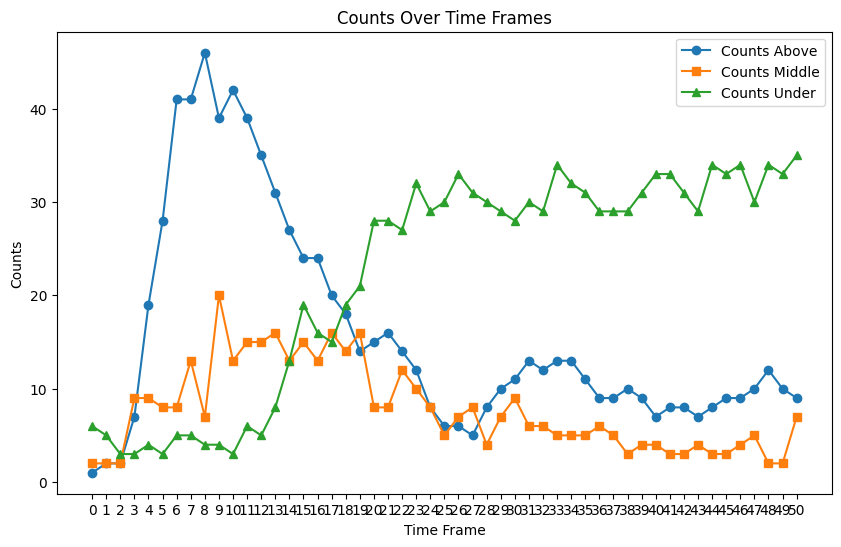

video saved asoutput_video.tif


In [24]:
close_processing_data = True #@param{type:"boolean"}
close_result_iamges = True #@param{type:"boolean"}
# middle_threshold = 0.001 #@param{type:"number"}

import re
def sort_key(name):
    numbers = re.findall(r'\d+', name)
    return int(numbers[0]) if numbers else 0
def pad(image_star, image_unet):
    if image_star.shape != image_unet.shape:
        new_height = max(image_star.shape[0], image_unet.shape[0])
        new_width = max(image_star.shape[1], image_unet.shape[1])

        padded_star = np.zeros((new_height, new_width), dtype=image_star.dtype) + 0
        padded_unet = np.zeros((new_height, new_width), dtype=image_unet.dtype) + 0

        padded_star[:image_star.shape[0], :image_star.shape[1]] = image_star
        padded_unet[:image_unet.shape[0], :image_unet.shape[1]] = image_unet

        return padded_star, padded_unet
    else:
        return image_star, image_unet

def count_dir(dir_path, save_dir, ori_save_dir, line_thickness=3):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(ori_save_dir):
        os.makedirs(ori_save_dir)

    color_map = {'above': 'red', 'tem': 'blue', 'under': 'green'}
    legend_elements = [Patch(facecolor=color, edgecolor=color, label=f'Label {label}') for label, color in color_map.items()]

    counts = {'counts_above':[], 'counts_tem':[], 'counts_under':[]}
    color_map2 = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}

    sorted_filenames = sorted(os.listdir(dir_path), key=sort_key)
    map = {1:'count_above', 2:'count_tem', 3:'count_under'}
    map2 = {1:'above', 2:'middle', 3:'under'}

    for filename in tqdm(sorted_filenames):
        if filename.startswith('.'):
            continue
        name = filename.split('.')[0]
        count = {'count_above':0, 'count_tem':0, 'count_under':0} # above label is 1, tem label is 2, under label is 3
        image_path = os.path.join(dir_path, filename)

        image_star = np.array(Image.open(f'./content/star/Predictions/{filename}'))
        image_unet = np.array(Image.open(f'./content/unet/Predictions/{filename}'))
        image_unet, image_star = pad(image_unet, image_star)
        with open(f'./content/star/coords/{name}.pkl', 'rb') as file:  #.pkl
            coord_loaded = pickle.load(file)
        original_image = np.array(Image.open(image_path).convert('RGB'))
        #print(f'orignal cells: {max(np.unique(image_star))}')


        original_image_with_ori_boundary = np.array(Image.open(image_path).convert('RGB'))
        for index, cells in enumerate(np.unique(image_star)):
            if cells ==0:
                continue

            mask = (image_star == index)
            total_pixels = np.sum(mask)
            labels_in_region = image_unet[mask]
            label_counts = Counter(labels_in_region)
            top_three = label_counts.most_common(4)
            if False:
                above = label_counts[1]
                under = label_counts[3]
                mid = label_counts[2]
                bg = label_counts[0]
                bg_threshold = 0.85

                if bg/total_pixels >= bg_threshold:
                    color = (122, 122, 122)
                    label = bg/total_pixels
                elif above == 0:
                    count['count_under'] += 1
                    color = (0, 255, 255)
                    label = 'count_under'
                elif under == 0:
                    count['count_above'] += 1
                    color = (255, 0, 255)
                    label = 'count_above'
                elif under/above >= middle_threshold:
                    count['count_tem'] += 1
                    color = (255, 255, 0)
                    label = 'count_tem'
                try:
                    dilation = ndimage.binary_dilation(mask)
                    erosion = ndimage.binary_erosion(mask)
                    boundary = dilation ^ erosion
                    tag = f"{index}_{label}"
                    y, x = np.where(boundary)
                    max_y, max_x = y.max(), x.max()
                    cv2.putText(original_image, tag, (max_x, max_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
                    original_image[boundary] = color
                except:
                    pass
            elif False:
                for label, _ in top_three:
                    # print(top_three,label,count)
                    boundary = np.zeros_like(mask, dtype=bool)
                    if label not in [0, 4]:
                        print('1')
                        # print(index)
                        # print(top_three,label,map[label],count)
                        count[map[label]] += 1
                        dilation = ndimage.binary_dilation(mask)
                        erosion = ndimage.binary_erosion(mask)
                        boundary = dilation ^ erosion
                        #boundary = ndimage.binary_dilation(mask) ^ mask
                        color = color_map2.get(label, (255, 255, 255))
                        tag = f"{map2[label]}"

                        y, x = np.where(boundary)
                        max_y, max_x = y.max(), x.max()

                        # print(f"{tag}, {map[label]} +1, color is {color}")
                        cv2.putText(original_image, tag, (max_x, max_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
                        if len(tag)>0:
                            # print(len(tag))
                            original_image[boundary] = color
                        boundary = np.zeros_like(mask, dtype=bool)
                        #original_image[boundary] = cv2.cvtColor(np.uint8([[[color]]]), cv2.COLOR_RGB2BGR)[0][0]
                        fig, ax = plt.subplots()
                        ax.imshow(original_image)
                        plt.show()
                        break
                    else:
                        print('2')
                        fig, ax = plt.subplots()
                        ax.imshow(original_image)
                        plt.show()
                        boundary = np.zeros_like(mask, dtype=bool)
                        #break
            else:
                label = find_nonzero(top_three)
                if label:
                    label = label[0]
                    count[map[label]] += 1
                    dilation = ndimage.binary_dilation(mask)
                    erosion = ndimage.binary_erosion(mask)
                    boundary = dilation ^ erosion
                    #boundary = ndimage.binary_dilation(mask) ^ mask
                    color = color_map2.get(label, (255, 255, 255))
                    tag = f"{map2[label]}"

                    y, x = np.where(boundary)
                    max_y, max_x = y.max(), x.max()

                    # print(f"{tag}, {map[label]} +1, color is {color}")
                    cv2.putText(original_image, tag, (max_x, max_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
                    if len(tag)>0:
                        # print(len(tag))
                        original_image[boundary] = color
                    boundary = np.zeros_like(mask, dtype=bool)


        if not close_processing_data:
            print(f'{filename}:{count}')
        #print(f'after cells: {sum(count.values())}')


        fig, ax = plt.subplots()
        ax.imshow(original_image)
        # ax.legend(handles=legend_elements, loc='lower left')
        ax.axis('off')
        count_text = "\n".join([f'Label {label}: {count}' for label, count in count.items()])
        plt.text(0.95, 0.05, count_text, verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes, color='white', fontsize=5, alpha = 0.5)

        # Save image
        plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight', dpi=200)
        if close_result_iamges:
            plt.close()
        else:
            plt.show()

        counts['counts_above'].append(count['count_above'])
        counts['counts_tem'].append(count['count_tem'])
        counts['counts_under'].append(count['count_under'])

    df = pd.DataFrame(counts)
    df.index.name = 'time frame'

    csv_filename = 'counts.csv'
    df.to_csv(csv_filename)

    print(f'counts.csv data saved')

    if not close_processing_data:
        print(counts)

    return counts

def find_nonzero(lst):
    for sub_lst in lst:
        if len(sub_lst) > 0 and sub_lst[0] != 0 and sub_lst[0] != 4:
            return sub_lst
    return False

counts = count_dir(Source_images_folder, './content/results/images', './content/results/oris')


df = pd.read_csv('counts.csv', index_col='time frame')

plt.figure(figsize=(10, 6))
plt.plot(df['counts_above'], label='Counts Above', marker='o')
plt.plot(df['counts_tem'], label='Counts Middle', marker='s')
plt.plot(df['counts_under'], label='Counts Under', marker='^')

plt.title('Counts Over Time Frames')
plt.xlabel('Time Frame')
plt.ylabel('Counts')
plt.xticks(range(len(df)))
plt.legend()
plt.show()

def create_tif_video(folder_path, output_filename):
    frames = []
    file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))

    for file in file_list:
        file_path = os.path.join(folder_path, file)
        frame = Image.open(file_path)
        frames.append(frame)

    frames[0].save(output_filename, save_all=True, append_images=frames[1:], duration=100, loop=0)
    print(f'video saved as{output_filename}')

folder_path = './content/results/images'
output_filename = 'output_video.tif'

create_tif_video(folder_path, output_filename)
#create_tif_video('./content/star/outputs', './content/star/outputs/starout.tif')
#create_tif_video('./content/unet/outputs', './content/unet/outputs/unetrout.tif')